In [69]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm

In [47]:
X_train = pd.read_csv('data/Training_set_values.csv', index_col='id')
X_test = pd.read_csv('data/Test_set_values.csv', index_col='id')
y_train = pd.read_csv('data/Training_set_labels.csv', index_col='id')

In [48]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [49]:
y_train.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


## Merging the X and y train data.

In [50]:
df = X_train.merge(y_train, on='id')

We merged the X train and y train data to build a dataframe that we could use to testing our different models on. The data set from where the data came did not have a y test dataset. We will split the merged dataset and create a hold out group later.

In [51]:
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Data Cleaning

In [52]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [53]:
df = df.drop(['scheme_name', 'date_recorded', 'wpt_name', 'subvillage', 'lga', 'ward', 'recorded_by', 
              'quantity_group', 'payment_type'], axis = 1)
df = df.fillna('missing', axis = 1)

With so many unique values for some features, onehotencoding creates more than 60,000 columns (out of a dataframe with 59,400 entries), making our models computationally prohibitive.  We use common sense and topical knowledge to eliminate some features and drop those columns from our dataframe.  Here are the dropped columns and our reasoning for excluding them: <br><br>
`date recorded`:  the age of the well is captured by the `construction_year` column <br>
`scheme_name`:  over 28,000 missing values <br>
`wpt_name`:  37,400 unique values <br>
`subvillage`: 19,288 unique values and location is captured elsewhere by `latitude` and `longitude` <br>
`lga`:  125 unique values and location is captured elsewhere by `latitude` and `longitude` <br>
`ward`:  2092 unique values and location is captured elsewhere by `latitude` and `longitude` <br>
`recorded_by`:  all values are the same <br>
`quantity_group`:  same as `quantity` <br>
`payment_type`:  same as `payment` <br>

We replaced NaN values with `missing` to keep the rows in our dataframe. We will onehotencode the data frame later.

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              59400 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   num_private            59400 non-null  int64  
 7   basin                  59400 non-null  object 
 8   region                 59400 non-null  object 
 9   region_code            59400 non-null  int64  
 10  district_code          59400 non-null  int64  
 11  population             59400 non-null  int64  
 12  public_meeting         59400 non-null  object 
 13  scheme_management      59400 non-null  object 
 14  permit                 59400 non-null  object 
 15

We are creating a hold out data set which we will test our final model on.

In [55]:
df, holdout = train_test_split(df, test_size = .1)

In [56]:
X = df.drop('status_group', axis=1)
y = df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [57]:
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region,region_code,...,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
48218,0.0,Churc,1481,RC C,35.025301,-8.241594,0,Rufiji,Iringa,11,...,user-group,never pay,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe
31229,0.0,Mkinga Distric Coun,0,DWE,38.861717,-4.824498,0,Pangani,Tanga,4,...,user-group,never pay,coloured,colored,enough,spring,spring,groundwater,dam,dam
9512,0.0,Government Of Tanzania,171,DWE,38.801542,-5.084752,0,Pangani,Tanga,4,...,user-group,never pay,soft,good,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe
64687,0.0,Norad/ Kidep,1304,DWE,30.837629,-3.642015,0,Lake Tanganyika,Kigoma,16,...,user-group,unknown,soft,good,enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe
8799,30.0,Lga,580,LGA,39.335264,-10.561165,0,Ruvuma / Southern Coast,Mtwara,90,...,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe


In [58]:
#X_train.to_csv('X_train.csv')
#X_test.to_csv('X_test.csv')
#y_train.to_csv('y_train.csv')
#y_test.to_csv('y_test.csv')
#
#df.to_csv('holdout_data.csv')

# Inferential Plots

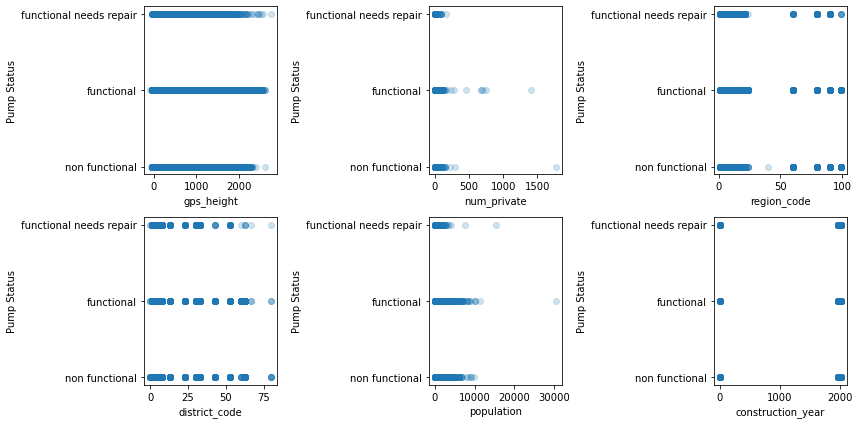

In [68]:
cols = df.select_dtypes('int64', 'float64').columns
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
fig.set_tight_layout(True)
for index, col in enumerate(cols): 
    ax = axes[index//3][index%3]
    ax.scatter(df[col], df.status_group, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("Pump Status")

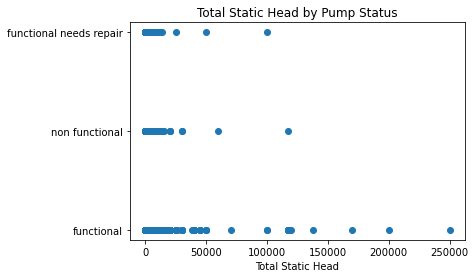

In [28]:
fig, ax = plt.subplots()
ax.scatter(df.amount_tsh, df.status_group)
ax.set_xlabel('Total Static Head')
ax.set_title('Total Static Head by Pump Status');

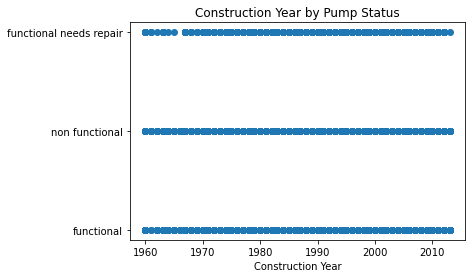

In [38]:
fig, ax = plt.subplots()
ax.scatter(df.construction_year.loc[df.construction_year != 0], 
           df.status_group.loc[df.construction_year !=0])
ax.set_xlabel('Construction Year')
ax.set_title('Construction Year by Pump Status');

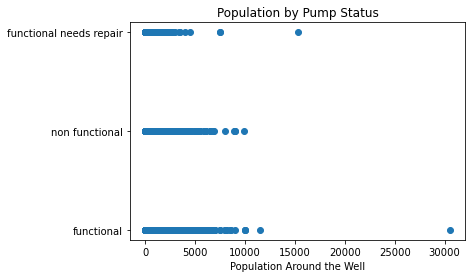

In [42]:
fig, ax = plt.subplots()
ax.scatter(df.population, df.status_group)
ax.set_xlabel('Population Around the Well')
ax.set_title('Population by Pump Status');

In [ ]:
sns.swarmplot(x=df.permit, y=df.status_group)

# Baseline Dummy Model

In [20]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [21]:
print('Accuracy Score Train:', dummy_model.score(X_train, y_train))
print('Accuracy Score Test:', dummy_model.score(X_test, y_test))

Accuracy Score Train: 0.543758573388203
Accuracy Score Test: 0.5437336326225215


In [22]:
log_loss_dummy = cross_val_score(dummy_model, X_train, y_train, scoring='neg_log_loss')
log_loss_dummy = -log_loss_dummy.mean()
print('Log Loss:', log_loss_dummy)

Log Loss: 15.75802061583991
